# Elo Merchant Category Recommendation - LynxKite feature boosting and LightGBM with StratifiedKFold
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

Inspired by [Feature engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/03.Feature-Engineering.ipynb)

In [14]:
import gc
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

warnings.filterwarnings("ignore")

random.seed(402)

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Feature engineering
Inspired by [Feature Engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/04.Feature-Engineering_2nd.ipynb)

### Train & test data

In [3]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"], index_col="card_id")
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 5 features in train set.


In [4]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"], index_col="card_id")
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 4 features in test set.


In [5]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_train['elapsed_days'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days

In [6]:
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])
df_test['elapsed_days'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

### Transactions

In [9]:
%%time
df_hist_trans = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Number of historical transactions: 29,112,361
CPU times: user 1min 25s, sys: 53 s, total: 2min 18s
Wall time: 3min 7s


In [10]:
%%time
df_new_trans = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
Number of new transactions: 1,963,031
CPU times: user 5.8 s, sys: 844 ms, total: 6.64 s
Wall time: 7.33 s


In [11]:
df_new_trans.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

Missing data handling (why these values?)

In [12]:
for df in [df_hist_trans, df_new_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

Date handling

In [13]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

In [14]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [15]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [16]:
df_hist_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_hist_trans['purchase_date'].dt.date).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

In [17]:
df_new_trans['month_diff'] = ((datetime.date(2018, 12, 1) - df_new_trans['purchase_date'].dt.date).dt.days)//30
df_new_trans['month_diff'] += df_new_trans['month_lag']

In [18]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3748.10 MB
Reduced memory usage: 1638.06 MB (56.3% reduction)


In [19]:
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 248.99 MB
Reduced memory usage: 106.71 MB (57.1% reduction)


#### Aggregation

In [20]:
def aggregate_transactions(df, prefix):
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'card_id': ['size'],
        'category_1': ['sum', 'mean'],
        
        'installments': ['sum', 'max', 'min', 'mean', 'var'],

        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_diff': ['mean'],
        'month_lag': ['max','min','mean','var'],

        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_date': ['max', 'min'],
        'purchase_dayofweek': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_year': ['nunique'],
        'purchase_weekend': ['sum', 'mean'],
        'purchase_weekofyear': ['nunique'],

        'subsector_id': ['nunique']
    }

    df['category_2_mean'] = df.groupby(['category_2'])['purchase_amount'].transform('mean')
    df['category_3_mean'] = df.groupby(['category_3'])['purchase_amount'].transform('mean')

    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_' + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(drop=False, inplace=True)
    df_agg[prefix + '_purchase_date_diff'] = (df_agg[prefix + '_purchase_date_max'] - df_agg[prefix + '_purchase_date_min']).dt.days
    df_agg[prefix + '_purchase_date_average'] = df_agg[prefix + '_purchase_date_diff']/df_agg[prefix + '_card_id_size']
    df_agg[prefix + '_purchase_date_uptonow'] = (datetime.datetime.today() - df_agg[prefix + '_purchase_date_max']).dt.days

    df = (df_agg.groupby('card_id').size().reset_index(name='{}_transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')
    return df_agg

In [21]:
df_hist_agg = aggregate_transactions(df_hist_trans, 'hist')
df_new_agg = aggregate_transactions(df_new_trans, 'new')

df_train = df_train.merge(df_hist_agg, on='card_id', how='left')
df_train = df_train.merge(df_new_agg, on='card_id', how='left')

df_test = df_test.merge(df_hist_agg, on='card_id', how='left')
df_test = df_test.merge(df_new_agg, on='card_id', how='left')

In [22]:
df_hist_agg[:3]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_card_id_size,hist_category_1_sum,hist_category_1_mean,hist_installments_sum,hist_installments_max,hist_installments_min,...,hist_purchase_hour_nunique,hist_purchase_month_nunique,hist_purchase_year_nunique,hist_purchase_weekend_sum,hist_purchase_weekend_mean,hist_purchase_weekofyear_nunique,hist_subsector_id_nunique,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow
0,C_ID_00007093c1,1,114.0,0.765101,149,28.0,0.187919,192,6,1,...,18,12,2,25.0,0.167785,39,13,377,2.530201,358
1,C_ID_0001238066,1,120.0,0.975610,123,2.0,0.016260,198,10,-1,...,20,6,2,52.0,0.422764,23,17,151,1.227642,357
2,C_ID_0001506ef0,1,62.0,0.939394,66,0.0,0.000000,1,1,0,...,15,11,2,32.0,0.484848,24,12,398,6.030303,368


In [23]:
del df_hist_trans, df_new_trans, df_hist_agg, df_new_agg
gc.collect()

105

In [24]:
df_train['hist_first_buy'] = (df_train['hist_purchase_date_min'] - df_train['first_active_month']).dt.days
df_train['new_first_buy'] = (df_train['new_purchase_date_min'] - df_train['first_active_month']).dt.days

df_test['hist_first_buy'] = (df_test['hist_purchase_date_min'] - df_test['first_active_month']).dt.days
df_test['new_first_buy'] = (df_test['new_purchase_date_min'] - df_test['first_active_month']).dt.days

In [25]:
for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
    df_train[f] = df_train[f].astype(np.int64) * 1e-9
    df_test[f] = df_test[f].astype(np.int64) * 1e-9

df_train['card_id_total'] = df_train['hist_card_id_size'] + df_train['new_card_id_size']
df_test['card_id_total'] = df_test['hist_card_id_size'] + df_test['new_card_id_size']

df_train['purchase_amount_total'] = df_train['hist_purchase_amount_sum'] + df_train['new_purchase_amount_sum']
df_test['purchase_amount_total'] = df_test['hist_purchase_amount_sum'] + df_test['new_purchase_amount_sum']

In [26]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [27]:
for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

### Loading features from LynxKite

In [16]:
df_lk_mc = pd.read_csv("LynxKite_export/LynxKite-modular_clusters_id_first.csv", index_col="card_id")
df_lk_mc = reduce_mem_usage(df_lk_mc)
print("{:,} observations and {} features in train set.".format(df_lk_mc.shape[0], df_lk_mc.shape[1]))

Starting memory usage:  7.45 MB
Reduced memory usage:  6.21 MB (16.7% reduction)
325,540 observations and 2 features in train set.


In [17]:
le = preprocessing.LabelEncoder()
le.fit(df_lk_mc['modular_clusters_id_first'])
df_lk_mc['modular_clusters_id_first'] = le.transform(df_lk_mc['modular_clusters_id_first'])

le.fit(df_lk_mc['modular_clusters_size_first'])
df_lk_mc['modular_clusters_size_first'] = le.transform(df_lk_mc['modular_clusters_size_first'])

In [18]:
df_lk_mc[:3]

,modular_clusters_id_first,modular_clusters_size_first
card_id,,
C_ID_7d9dee148a,4926,14
C_ID_a7d06696b1,14326,25
C_ID_b9aeb45f7b,22988,19


In [9]:
df_lk_tt = pd.read_csv("LynxKite_export/LynxKite-target_top-target_wavg_purchase_amount-wavg_purchase_date.csv")
df_lk_tt = reduce_mem_usage(df_lk_tt)
print("{:,} observations and {} features in train set.".format(df_lk_tt.shape[0], df_lk_tt.shape[1]))

Starting memory usage: 52.16 MB
Reduced memory usage: 21.11 MB (59.5% reduction)
325,540 observations and 21 features in train set.


In [10]:
df_lk_tt[:3]

,card_id,neighborhood_target_top_avg_average,neighborhood_target_top_avg_first,neighborhood_target_top_avg_max,neighborhood_target_top_avg_min,neighborhood_target_top_avg_most_common,neighborhood_target_bottom_avg_average,neighborhood_target_bottom_avg_first,neighborhood_target_bottom_avg_max,neighborhood_target_bottom_avg_min,...,neighborhood_target_wavg_purchase_amount_average,neighborhood_target_wavg_purchase_amount_first,neighborhood_target_wavg_purchase_amount_max,neighborhood_target_wavg_purchase_amount_min,neighborhood_target_wavg_purchase_amount_most_common,neighborhood_target_wavg_purchase_date_average,neighborhood_target_wavg_purchase_date_first,neighborhood_target_wavg_purchase_date_max,neighborhood_target_wavg_purchase_date_min,neighborhood_target_wavg_purchase_date_most_common
0,C_ID_f26081eca3,0.275635,0.098267,0.475342,0.000000,0.214600,6.066406,12.468750,35.125000,0.270508,...,297.294617,62.974602,1039.092651,13.289358,135.277939,25528.681641,2833.434326,248088.328125,2.705562,137.098816
1,C_ID_0ba76b9ea2,0.107361,0.218750,0.218750,0.016052,0.016052,6.550781,1.922852,8.867188,1.922852,...,92.109688,28.921249,137.276337,28.921249,137.276337,12431.413086,1031.070190,27440.634766,1031.070190,27440.634766
2,C_ID_44946612a5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merging

In [32]:
df_train = df_train.merge(df_lk_mc, on='card_id', how='left')
df_test = df_test.merge(df_lk_mc, on='card_id', how='left')

In [33]:
df_train = df_train.merge(df_lk_tt, on='card_id', how='left')
df_test = df_test.merge(df_lk_tt, on='card_id', how='left')

### Training
[LightGBM parameter tuning](https://testlightgbm.readthedocs.io/en/latest/Parameters-tuning.html)<br/>
[What is LightGBM, How to implement it? How to fine tune the parameters?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [34]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
target = df_train['target']
del df_train['target']

In [84]:
%%time
param = {
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "bagging_seed": 1,
    "boosting": "random_forest",

    "feature_fraction": 0.8,
    "feature_fraction_seed": 1,

    "lambda_l1": 0.25,
    #"lambda_l2": 0.001,
    "learning_rate": 0.1,

    "max_bin": 5,
    'max_depth': 2,
    "metric": "rmse",
    "min_data_in_leaf": 20,
    "min_gain_to_split": 0.1,
    #"min_sum_hessian_in_leaf": 1e-3,
    #"min_child_samples": 20,
    #"num_iterations": 100,
    "num_boost_round": 100,
    "num_leaves": 2,

    "objective": "regression",

    "random_state": 1,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['outliers'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.44914	valid_1's rmse: 3.42091
[200]	training's rmse: 3.42321	valid_1's rmse: 3.39666
[300]	training's rmse: 3.41361	valid_1's rmse: 3.38738
[400]	training's rmse: 3.40794	valid_1's rmse: 3.38198
[500]	training's rmse: 3.40376	valid_1's rmse: 3.37818
[600]	training's rmse: 3.40048	valid_1's rmse: 3.37528
[700]	training's rmse: 3.39781	valid_1's rmse: 3.373
[800]	training's rmse: 3.39559	valid_1's rmse: 3.37112
[900]	training's rmse: 3.39374	valid_1's rmse: 3.36974
[1000]	training's rmse: 3.39213	valid_1's rmse: 3.36838
[1100]	training's rmse: 3.3907	valid_1's rmse: 3.36716
[1200]	training's rmse: 3.38947	valid_1's rmse: 3.36627
[1300]	training's rmse: 3.3884	valid_1's rmse: 3.36551
[1400]	training's rmse: 3.38745	valid_1's rmse: 3.36483
[1500]	training's rmse: 3.3866	valid_1's rmse: 3.36419
[1600]	training's rmse: 3.38585	valid_1's rmse: 3.36358
[1700]	training's rmse: 3.38514	valid_1's rmse

[1900]	training's rmse: 3.37523	valid_1's rmse: 3.3982
[2000]	training's rmse: 3.37471	valid_1's rmse: 3.39788
[2100]	training's rmse: 3.37422	valid_1's rmse: 3.39755
[2200]	training's rmse: 3.37378	valid_1's rmse: 3.39724
[2300]	training's rmse: 3.37338	valid_1's rmse: 3.3969
[2400]	training's rmse: 3.37299	valid_1's rmse: 3.39661
[2500]	training's rmse: 3.37266	valid_1's rmse: 3.3963
[2600]	training's rmse: 3.37234	valid_1's rmse: 3.39606
[2700]	training's rmse: 3.37205	valid_1's rmse: 3.39588
[2800]	training's rmse: 3.37178	valid_1's rmse: 3.39564
[2900]	training's rmse: 3.37154	valid_1's rmse: 3.39557
[3000]	training's rmse: 3.37128	valid_1's rmse: 3.39536
[3100]	training's rmse: 3.37107	valid_1's rmse: 3.39507
[3200]	training's rmse: 3.37086	valid_1's rmse: 3.39499
[3300]	training's rmse: 3.37067	valid_1's rmse: 3.39487
Early stopping, best iteration is:
[3285]	training's rmse: 3.3707	valid_1's rmse: 3.39485

Fold 5.
Training until validation scores don't improve for 100 rounds.
[

In [85]:
cv_score = np.sqrt(mean_squared_error(oof, target))
print("CV score: {:.6f}".format(cv_score))

CV score: 3.379347


In [2]:
confusion_matrix(target, predictions)

NameError: name 'target' is not defined

In [ ]:
accuracy_score(target, predictions)

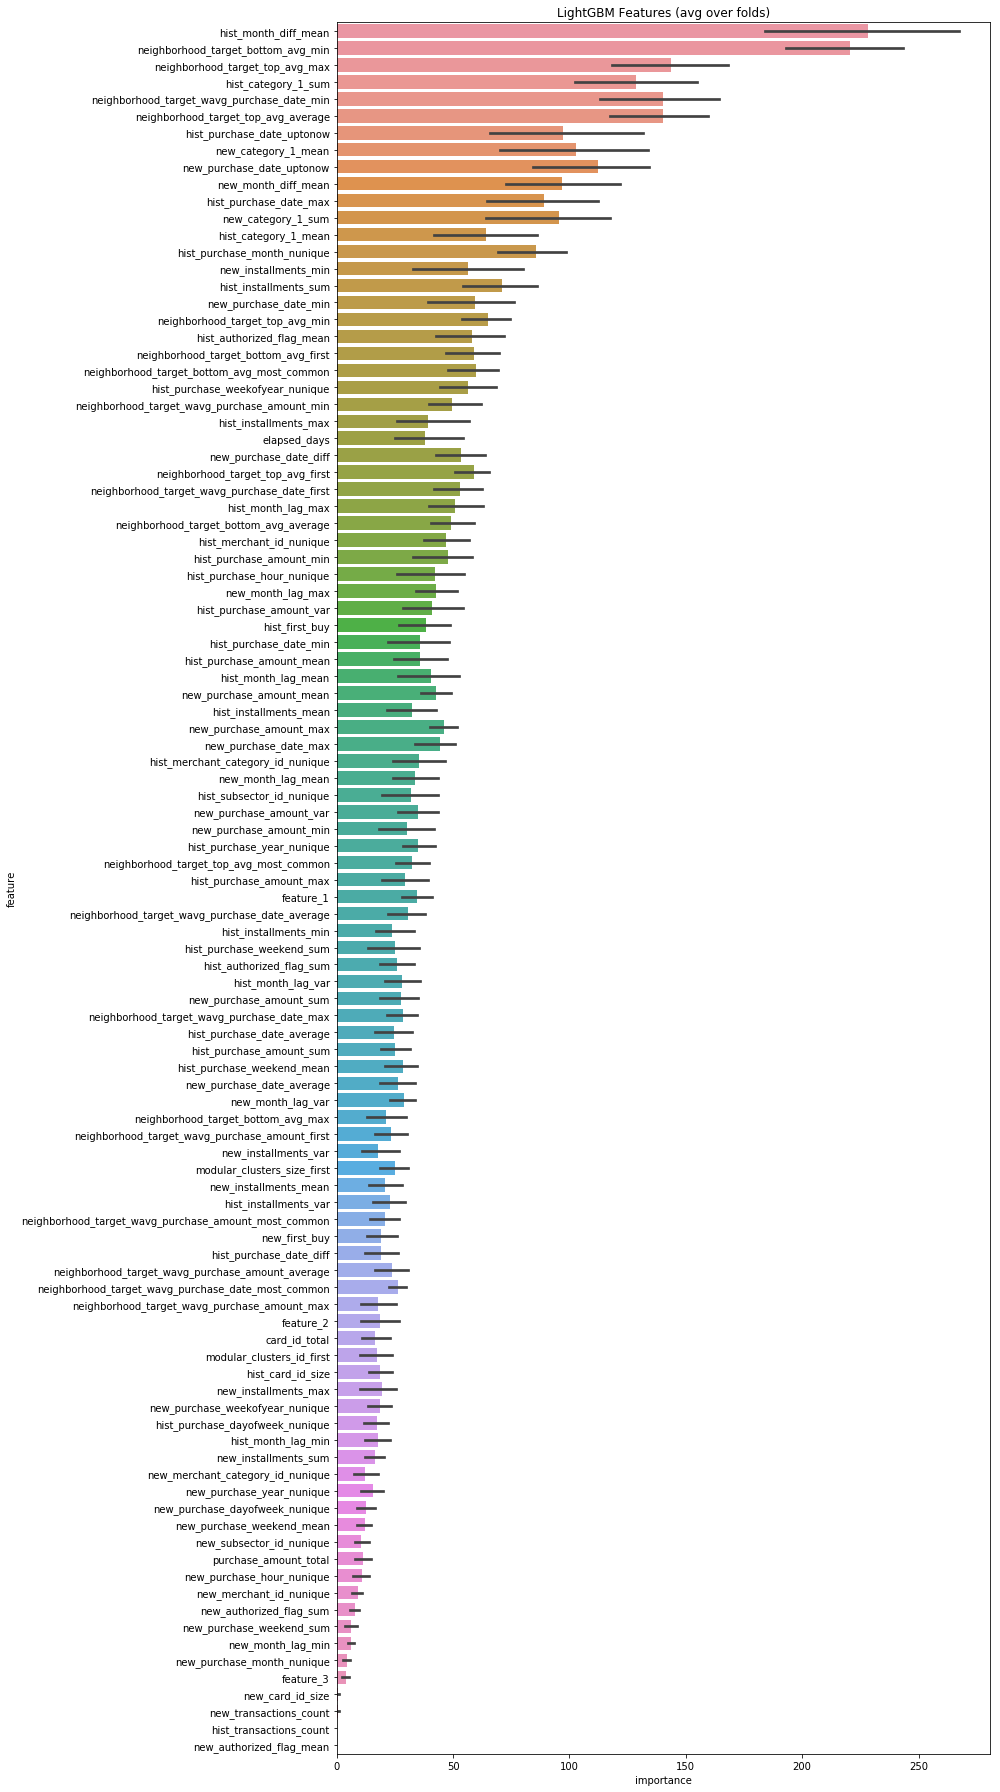

In [80]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [81]:
best_features[best_features['importance'] == 0]

,feature,importance,fold
4,hist_transactions_count,0,1
42,new_authorized_flag_mean,0,1
43,new_card_id_size,0,1
4,hist_transactions_count,0,2
40,new_transactions_count,0,2
42,new_authorized_flag_mean,0,2
4,hist_transactions_count,0,3
42,new_authorized_flag_mean,0,3
43,new_card_id_size,0,3
4,hist_transactions_count,0,4


In [86]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/regression_with_lk_{:.6f}.csv".format(cv_score), index=False)

[Just Train Data - LGB & XGB & CatBoost w/ Blending](https://www.kaggle.com/silverstone1903/just-train-data-lgb-xgb-catboost-w-blending/data)<br/>
[MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75935